In [5]:
import pandas as pd
import json
import ast
import plotly.express as px
import math

In [9]:
jamstones = pd.read_csv('jamstones.csv')
lavval = pd.read_csv('lavval.csv')
newagefsg = pd.read_csv('newage.csv')

In [10]:
jamstones[['id', 'tags', 'current_total_discounts', 'current_total_price','discount_codes','customer', 'discount_applications','line_items', 'total_price', 'shipping_address']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8082 non-null   int64  
 1   tags                     4266 non-null   object 
 2   current_total_discounts  8082 non-null   float64
 3   current_total_price      8082 non-null   float64
 4   discount_codes           8082 non-null   object 
 5   customer                 7812 non-null   object 
 6   discount_applications    8082 non-null   object 
 7   line_items               8082 non-null   object 
 8   total_price              8082 non-null   float64
 9   shipping_address         6748 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 631.5+ KB


### Preprocessing

In [11]:
# Preprocessing

#helper functions
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

def source(x):
    if 'shopee' in x.lower():
        return 'Shopee'
    elif 'instagram' in x.lower():
        return 'Instagram'
    else:
        return 'Shopify'
    
def check_format(row):
    if type(row)==str:
        if ((row[0] == '['and row[len(row)-1] == ']' and row[1] == '{'and row[len(row)-2] == '}') or (row[0] == '{'and row[len(row)-1] == '}') )and len(row)>10:
            return True
    else:
        return False

def preprocessing(df):
    df_copy = df.copy()[['id', 'tags', 'current_total_discounts', 'current_total_price','discount_codes','customer', 'discount_applications','line_items', 'total_price', 'shipping_address']]
    df_copy.tags.fillna("Shopify", inplace = True)
    df_copy['format_check'] = df_copy.apply(lambda x: 'pass' if check_format(x.line_items) else math.nan, axis=1)
    df_copy['format_check'] = df_copy.apply(lambda x: 'pass' if (check_format(x.discount_codes) and x.format_check!=math.nan) else math.nan, axis=1)
    df_copy['format_check'] = df_copy.apply(lambda x: 'pass' if (check_format(x.customer) and x.format_check!=math.nan) else math.nan, axis=1)
    df_copy.dropna(inplace = True)
    
    func = np.vectorize(source)
    df_copy['source'] = func(df_copy["tags"])
    df_copy = trim_all_columns(df_copy)
    df_copy['has_discount'] = np.where(df_copy['discount_codes']=='[]', True, False)
    
    df_copy.line_items = df_copy.line_items.apply(eval).apply(json.dumps)
    df_copy.customer = df_copy.customer.apply(eval).apply(json.dumps)
    df_copy.discount_codes = df_copy.discount_codes.apply(eval).apply(json.dumps)
    df_copy.discount_applications = df_copy.discount_applications.apply(eval).apply(json.dumps)
    df_copy.shipping_address = df_copy.shipping_address.apply(eval).apply(json.dumps)

    # Column names that contain JSON
    json_cols = ['customer', 'discount_codes','discount_applications','line_items','shipping_address']

    def clean_json(x):
        "Create apply function for decoding JSON"
        return json.loads(x)

    # Apply the function column wise to each column of interest
    for x in json_cols:
        df_copy[x] = df_copy[x].apply(clean_json)        
    
    df_copy['customer_id'] = df_copy.apply(lambda x: x.customer['id'], axis=1)
    df_copy['freq'] = df_copy.groupby('customer_id')['customer_id'].transform('count')
    
    discount_codes_list = df_copy['discount_codes'].tolist()
    codes_list = [row[0]['code'] if row!=[] else 'None' for row in discount_codes_list ]
    df_copy['codes'] = codes_list

    
    return df_copy
   


In [12]:
df_copy=preprocessing(jamstones)
df_copy

,id,tags,current_total_discounts,current_total_price,discount_codes,customer,discount_applications,line_items,total_price,shipping_address,format_check,source,has_discount,customer_id,freq,codes
0,4093536043104,shopee,7.13,52.67,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5198168719456, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557966286944, 'admin_graphql_api_id'...",52.67,"{'first_name': 'P*****g', 'address1': '11*****...",pass,Shopee,False,5198168719456,11,"Shopee Transaction Fee, Shopee Vouchers"
1,4093506060384,shopee,6.96,52.84,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5366028140640, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557885513824, 'admin_graphql_api_id'...",52.84,"{'first_name': 'Ng Jo Yi', 'address1': 'BEDOK ...",pass,Shopee,False,5366028140640,1,"Shopee Transaction Fee, Shopee Vouchers"
2,4093373120608,shopee,0.07,3.93,"[{'code': 'Shopee Transaction Fee', 'amount': ...","{'id': 5356590334048, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557541810272, 'admin_graphql_api_id'...",3.93,"{'first_name': 'AijaBeautyHalawa', 'address1':...",pass,Shopee,False,5356590334048,2,Shopee Transaction Fee
3,4093166813280,shopee,0.00,0.00,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5198168719456, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557052059744, 'admin_graphql_api_id'...",52.67,"{'first_name': 'P*****g', 'address1': '11*****...",pass,Shopee,False,5198168719456,11,"Shopee Transaction Fee, Shopee Vouchers"
4,4092837363808,shopee,9.96,89.74,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5365589999712, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10556246884448, 'admin_graphql_api_id'...",89.74,"{'first_name': 'Tan Li Ting', 'address1': '968...",pass,Shopee,False,5365589999712,1,"Shopee Transaction Fee, Shopee Vouchers"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8071,2570874159200,Shopify,4.00,153.80,"[{'code': 'FREESHIPPING', 'amount': '4.00', 't...","{'id': 3451201290336, 'email': 'joselyn999@hot...","[{'target_type': 'shipping_line', 'type': 'dis...","[{'id': 5394215796832, 'admin_graphql_api_id':...",153.80,"{'first_name': 'Joselyn', 'address1': '82 Stra...",pass,Shopify,False,3451201290336,1,FREESHIPPING
8075,2570778706016,Shopify,0.00,49.90,[],"{'id': 3451115405408, 'email': 'bimorphia@hotm...",[],"[{'id': 5394021417056, 'admin_graphql_api_id':...",49.90,"{'first_name': 'Josephine', 'address1': 'Blk 2...",pass,Shopify,True,3451115405408,2,None
8076,2570731782240,Shopify,4.00,129.80,"[{'code': 'FREESHIPPING', 'amount': '4.00', 't...","{'id': 3451077099616, 'email': 'justbeingme-ev...","[{'target_type': 'shipping_line', 'type': 'dis...","[{'id': 5393924325472, 'admin_graphql_api_id':...",129.80,"{'first_name': 'Eve', 'address1': '669 Hougang...",pass,Shopify,False,3451077099616,1,FREESHIPPING
8077,2570730242144,Shopify,4.00,225.50,"[{'code': 'FREESHIPPING', 'amount': '4.00', 't...","{'id': 3451077754976, 'email': 'yanniedonked@g...","[{'target_type': 'shipping_line', 'type': 'dis...","[{'id': 5393920983136, 'admin_graphql_api_id':...",225.50,"{'first_name': 'YQ', 'address1': '107B Tampine...",pass,Shopify,False,3451077754976,1,FREESHIPPING


## Concat df

In [14]:
jamstones_preprocessed = preprocessing(jamstones)
lavval_preprocessed = preprocessing(lavval)
newagefsg_preprocessed = preprocessing(newagefsg)

In [16]:
new_df = pd.concat([jamstones_preprocessed, lavval_preprocessed, newagefsg_preprocessed], ignore_index=True)
new_df

,id,tags,current_total_discounts,current_total_price,discount_codes,customer,discount_applications,line_items,total_price,shipping_address,format_check,source,has_discount,customer_id,freq,codes
0,4093536043104,shopee,7.13,52.67,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5198168719456, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557966286944, 'admin_graphql_api_id'...",52.67,"{'first_name': 'P*****g', 'address1': '11*****...",pass,Shopee,False,5198168719456,11,"Shopee Transaction Fee, Shopee Vouchers"
1,4093506060384,shopee,6.96,52.84,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5366028140640, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557885513824, 'admin_graphql_api_id'...",52.84,"{'first_name': 'Ng Jo Yi', 'address1': 'BEDOK ...",pass,Shopee,False,5366028140640,1,"Shopee Transaction Fee, Shopee Vouchers"
2,4093373120608,shopee,0.07,3.93,"[{'code': 'Shopee Transaction Fee', 'amount': ...","{'id': 5356590334048, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557541810272, 'admin_graphql_api_id'...",3.93,"{'first_name': 'AijaBeautyHalawa', 'address1':...",pass,Shopee,False,5356590334048,2,Shopee Transaction Fee
3,4093166813280,shopee,0.00,0.00,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5198168719456, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10557052059744, 'admin_graphql_api_id'...",52.67,"{'first_name': 'P*****g', 'address1': '11*****...",pass,Shopee,False,5198168719456,11,"Shopee Transaction Fee, Shopee Vouchers"
4,4092837363808,shopee,9.96,89.74,"[{'code': 'Shopee Transaction Fee, Shopee Vouc...","{'id': 5365589999712, 'email': None, 'accepts_...","[{'target_type': 'line_item', 'type': 'manual'...","[{'id': 10556246884448, 'admin_graphql_api_id'...",89.74,"{'first_name': 'Tan Li Ting', 'address1': '968...",pass,Shopee,False,5365589999712,1,"Shopee Transaction Fee, Shopee Vouchers"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11120,2676186022049,Shopify,0.00,62.90,[],"{'id': 3953183359137, 'email': None, 'accepts_...",[],"[{'id': 5788143878305, 'admin_graphql_api_id':...",62.90,"{'first_name': 'Yana', 'address1': 'Blk 815 Ju...",pass,Shopify,True,3953183359137,4,None
11121,2674319327393,Shopify,4.00,135.00,"[{'code': 'FS100', 'amount': '4.00', 'type': '...","{'id': 3948893175969, 'email': 'peiling.ng.1@g...","[{'target_type': 'shipping_line', 'type': 'dis...","[{'id': 5785053888673, 'admin_graphql_api_id':...",135.00,"{'first_name': 'Pei Ling', 'address1': '8A Lor...",pass,Shopify,False,3948893175969,1,FS100
11122,2673968054433,Shopify,0.00,61.00,[],"{'id': 3948014928033, 'email': 'maytbl59@gmail...",[],"[{'id': 5784513413281, 'admin_graphql_api_id':...",61.00,"{'first_name': 'May May', 'address1': 'Blk 505...",pass,Shopify,True,3948014928033,1,None
11123,2673190043809,Shopify,0.00,91.00,[],"{'id': 3946100785313, 'email': 'hltim@singnet....",[],"[{'id': 5783188865185, 'admin_graphql_api_id':...",91.00,"{'first_name': 'Hwee Ling', 'address1': 'Blk 2...",pass,Shopify,True,3946100785313,4,None


In [17]:
#aggregate df no preprocessing
df = new_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11125 entries, 0 to 11124
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11125 non-null  int64  
 1   tags                     11125 non-null  object 
 2   current_total_discounts  11125 non-null  float64
 3   current_total_price      11125 non-null  float64
 4   discount_codes           11125 non-null  object 
 5   customer                 11125 non-null  object 
 6   discount_applications    11125 non-null  object 
 7   line_items               11125 non-null  object 
 8   total_price              11125 non-null  float64
 9   shipping_address         11125 non-null  object 
 10  format_check             11125 non-null  object 
 11  source                   11125 non-null  object 
 12  has_discount             11125 non-null  bool   
 13  customer_id              11125 non-null  int64  
 14  freq                  

## Proportion of orders with and without discounts

In [54]:
df_copy.has_discount.value_counts()

True     4304
False    2406
Name: has_discount, dtype: int64

[[True, False], [7774, 3351]]

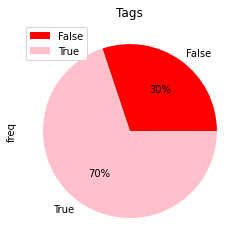

In [22]:
def proportion_discounts(df):    
#     df_copy = preprocessing(df)
    t = new_df.has_discount.value_counts()
    t_df = pd.DataFrame({'value':t.index, 'freq':t.values})
    #pie chart
    t_df.groupby(['value']).sum().plot(kind='pie', y='freq', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Tags')
    x = t_df.value.tolist()
    y = t_df.freq.tolist()
    return [x, y]

# proportion_discounts(df)
proportion_discounts(new_df)

## Source of Orders

[['Shopify', 'Shopee', 'Instagram'], [6221, 4672, 232]]

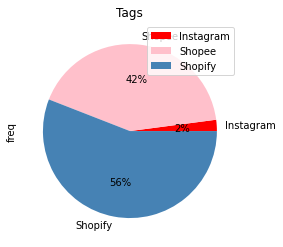

In [23]:
def source_orders(df):
#     df_copy = preprocessing(df)
    sf = new_df.source.value_counts()
    temp = pd.DataFrame({'source':sf.index, 'freq':sf.values})
    #pie chart
    temp.groupby(['source']).sum().plot(kind='pie', y='freq', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Tags')
    x = temp.source.tolist()
    y = temp.freq.tolist()
    return [x, y]

# source_orders(df)
source_orders(new_df)

## Top ten discount codes 

[['Shopee Transaction Fee, Shopee Vouchers',
  'Shopee Transaction Fee',
  'FREESHIPPING',
  'FS100',
  'Custom discount',
  '15years',
  'XMAS10',
  '44SALE',
  'Shopee Transaction Fee, Shopee Vouchers, Shopee Bundle Deal',
  'Shopee Transaction Fee, Shopee Bundle Deal'],
 [1196, 1105, 252, 129, 90, 77, 74, 72, 59, 38]]

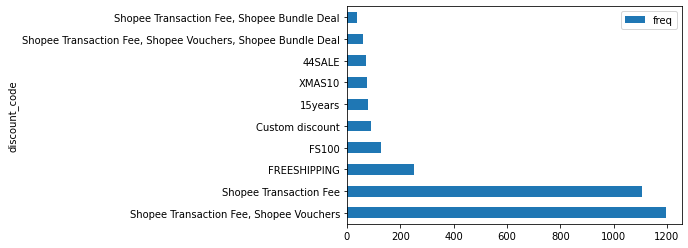

In [24]:
def top_discount_codes(df):
#     df_copy = preprocessing(df)
    discount_series = new_df.codes.value_counts()
    top_discount_codes = pd.DataFrame({'discount_code':discount_series.index, 'freq':discount_series.values})
    top_discount_codes = top_discount_codes[1:]
    top10_codes = top_discount_codes[:10]
    ax = top10_codes.plot.barh(x='discount_code', y='freq')
    x = top10_codes.discount_code.tolist()
    y = top10_codes.freq.tolist()
    return [x, y]
    

# top_discount_codes(df)
top_discount_codes(new_df)

## Proportion of discounted and undiscounted orders per customer (top 10)

[[5219610493024,
  3955295748257,
  5195318558816,
  5218605006944,
  5195470078048,
  3206458179627,
  5212559212640,
  4047350071457,
  5212521398368,
  5208055218272],
 [50, 42, 30, 14, 28, 19, 23, 23, 10, 21],
 [0, 1, 7, 22, 1, 7, 2, 0, 11, 0]]

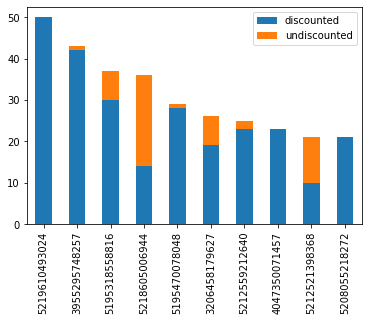

In [25]:
def getUniqueItems(d):
    result = {}
    for key,value in d.items():
        if key not in result.keys():
            result[key] = value
    return result

def proportion_discounts(df):
#     df_copy = preprocessing(df)
    
    discount = new_df.drop(new_df[new_df.has_discount == False].index)
    no_discount = new_df.drop(new_df[new_df.has_discount == True].index)
    discount['freq'] = discount.groupby('customer_id')['customer_id'].transform('count')
    no_discount['freq'] = no_discount.groupby('customer_id')['customer_id'].transform('count')
    discount_dict = dict(zip(discount.customer_id, discount.freq))
    no_discount_dict = dict(zip(no_discount.customer_id, no_discount.freq))
    new_discount_dict = getUniqueItems(discount_dict)
    new_no_discount_dict = getUniqueItems(no_discount_dict)
    d_keys = list(new_discount_dict.keys())
    n_keys = list(new_no_discount_dict.keys())
    customer_df=pd.DataFrame(columns = ['customer_id', 'discounted_transactions', 'undiscounted_transactions'])
    customer_df['customer_id'] = new_df['customer_id'].unique()
    customers = customer_df.customer_id.tolist()
    discount = [new_discount_dict[customer] if customer in d_keys else 0 for customer in customers ]
    no_discount = [new_no_discount_dict[customer] if customer in n_keys else 0 for customer in customers ]
    customer_df['discounted_transactions'] = discount
    customer_df['undiscounted_transactions'] = no_discount
    customer_df['freq'] = customer_df['discounted_transactions']+customer_df['undiscounted_transactions']
    top10=customer_df.sort_values(by='freq', ascending=False).head(10)
    
    #customer_id
    x = top10.customer_id.tolist()
    #discounted
    y1 = top10.discounted_transactions.tolist()
    #undiscounted
    y2 = top10.undiscounted_transactions.tolist()
    
    df = pd.DataFrame({'discounted': y1,
                   'undiscounted': y2}, index=x)

    ax = df.plot.bar(stacked=True)
    
    # x, y1, y2
    return [x, y1, y2]

# proportion_discounts(df)
proportion_discounts(new_df)

## Proportion of revenue with discounts and without discounts

[['Total discounts', 'Total revenue'], [62746.28999999999, 954237.22]]

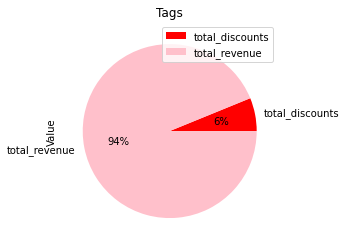

In [16]:
#loop thru items in each row in line items and sum up the total_discount (using total_discount from line_items)
# def total_discount_per_transaction(row):
#     num_items = len(row)
#     total_discount = 0
#     for i in range(num_items):
#         total_discount+=float(row[i]['total_discount'])
#     return total_discount

# def total_discounts_total_revenue(df):
#     df_copy = preprocessing(df)
#     line_items_list = df_copy.line_items.tolist()
#     total_discount_per_transaction_list = [total_discount_per_transaction(row) for row in line_items_list]
#     df_copy['discount_per_transaction'] = total_discount_per_transaction_list
#     total_discounts = df_copy['discount_per_transaction'].sum()
#     total_revenue = df_copy['total_price'].sum()
    
#     #pie chart
#     data = [['total_discounts', total_discounts], ['total_revenue', total_revenue]]
#     temp_df = pd.DataFrame(data, columns = ['Title', 'Value'])
    
# #     fig = px.pie(temp_df, values='Title', names='Value')
# #     fig.show()
    
#     #pie chart
#     temp_df.groupby(['Title']).sum().plot(kind='pie', y='Value', autopct='%1.0f%%',
#                                 colors = ['red', 'pink', 'steelblue'],
#                                 title='Tags')
            
#     return (total_discounts, total_revenue)

#loop thru items in each row in line items and sum up the value (using value from discount_applications)
def total_discount_per_transaction(row):
    total_discount = 0
    total_discount+= float(row[0]['value'])

    return total_discount

def total_discounts_total_revenue(df):
#     df_copy = preprocessing(df)
    discount_applications_list = df_copy.discount_applications.tolist()
    total_discount_per_transaction_list = [total_discount_per_transaction(row)if row!=[] else 0 for row in discount_applications_list ]
    df_copy['discount_per_transaction'] = total_discount_per_transaction_list
    total_discounts = df_copy['discount_per_transaction'].sum()
    total_revenue = df_copy['total_price'].sum()
    
    #pie chart
    data = [['total_discounts', total_discounts], ['total_revenue', total_revenue]]
    temp_df = pd.DataFrame(data, columns = ['Title', 'Value'])
    
#     fig = px.pie(temp_df, values='Title', names='Value')
#     fig.show()
    
    #pie chart
    temp_df.groupby(['Title']).sum().plot(kind='pie', y='Value', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Tags')
    
    x = ['Total discounts', 'Total revenue']
    y = [total_discounts, total_revenue]
            
    return [x, y]

# total_discounts_total_revenue(df)
total_discounts_total_revenue(new_df)

#### Using current_total_discounts and current_total_price

[['Total discounts', 'Total revenue'], [29755.88, 934647.36]]

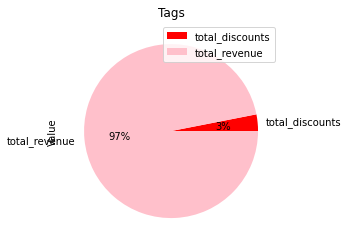

In [27]:
def total_discounts_total_revenue(df):
    total_discounts = new_df['current_total_discounts'].sum()
    total_revenue = new_df['current_total_price'].sum()
    
    data = [['total_discounts', total_discounts], ['total_revenue', total_revenue]]
    temp_df = pd.DataFrame(data, columns = ['Title', 'Value'])
    
    #pie chart
    temp_df.groupby(['Title']).sum().plot(kind='pie', y='Value', autopct='%1.0f%%',
                                colors = ['red', 'pink', 'steelblue'],
                                title='Tags')
    
    x = ['Total discounts', 'Total revenue']
    y = [total_discounts, total_revenue]
            
    return [x, y]
    
    
total_discounts_total_revenue(new_df)   

In [34]:
def total_discounts_total_revenue(df):
    total_discounts = df['current_total_discounts'].sum()
    total_revenue = df['current_total_price'].sum()
    
    x = ['Total discounts', 'Total revenue']
    y = [total_discounts, total_revenue]
            
    return [x, y]

#proportion of revenue with discounts and without discounts
def get_total_discounts_total_revenue():
    
#     jamstones = retrieve_jamstones()
#     lavval = retrieve_lavval()
#     newagefsg = retrieve_newagefsg()

    jamstones_preprocessed = preprocessing(jamstones)
    lavval_preprocessed = preprocessing(lavval)
    newagefsg_preprocessed = preprocessing(newagefsg)
    aggregate = pd.concat([jamstones_preprocessed, lavval_preprocessed, newagefsg_preprocessed], ignore_index=True)

    total_discounts_total_revenue_jamstones = total_discounts_total_revenue(jamstones_preprocessed)
    total_discounts_total_revenue_lavval = total_discounts_total_revenue(lavval_preprocessed)
    total_discounts_total_revenue_newagefsg = total_discounts_total_revenue(newagefsg_preprocessed)
    total_discounts_total_revenue_aggregate = total_discounts_total_revenue(aggregate)

    return {'Jamstones': total_discounts_total_revenue_jamstones, 
            'Lavval': total_discounts_total_revenue_lavval, 
            'NewAgeFSG': total_discounts_total_revenue_newagefsg, 
            'Aggregate': total_discounts_total_revenue_aggregate}

get_total_discounts_total_revenue()

{'Jamstones': [['Total discounts', 'Total revenue'],
  [14363.930000000002, 524248.96]],
 'Lavval': [['Total discounts', 'Total revenue'], [5502.84, 181236.81]],
 'NewAgeFSG': [['Total discounts', 'Total revenue'],
  [9889.11, 229161.58999999997]],
 'Aggregate': [['Total discounts', 'Total revenue'], [29755.88, 934647.36]]}